In [7]:
%matplotlib inline

#   Copyright (c) 2010-2014, MIT Probabilistic Computing Project
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn

import bayeslite
import bdbcontrib
from bdbcontrib.foreign.composer import Composer

from keplers_law import compute_period, compute_a, compute_T, EARTH_RADIUS

matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['figure.figsize'] = 14, 12
matplotlib.rcParams['axes.grid'] = True

# Convenient query wrapper.
def q(bdb, query):
    df = bdb.execute(query)
    return bdbcontrib.cursor_to_df(df)

# Load the database with the default model.
bdb_default = bayeslite.bayesdb_open('sat2.bdb')

In [8]:
# Load the database with the default model composed with Kepler's laws.
bdb_kepler = bayeslite.bayesdb_open('sat.bdb')
bayeslite.bayesdb_register_metamodel(bdb_kepler, Composer())
bdb_kepler.execute("""
    CREATE GENERATOR sat_custom FOR satellites USING composer(
        default (
            Country_of_Operator CATEGORICAL, Operator_Owner CATEGORICAL,
            Users CATEGORICAL, Purpose CATEGORICAL,
            Type_of_Orbit CATEGORICAL, Perigee_km NUMERICAL,
            Apogee_km NUMERICAL, Eccentricity NUMERICAL,
            Launch_Mass_kg NUMERICAL, Dry_Mass_kg NUMERICAL,
            Power_watts NUMERICAL, Date_of_Launch NUMERICAL,
            Anticipated_Lifetime NUMERICAL, Contractor CATEGORICAL,
            Country_of_Contractor CATEGORICAL, Launch_Site CATEGORICAL,
            Launch_Vehicle CATEGORICAL,
            Source_Used_for_Orbital_Data CATEGORICAL,
            longitude_radians_of_geo NUMERICAL, Inclination_radians NUMERICAL
        )
        random_forest (
            Type_of_Orbit CATEGORICAL
                GIVEN Apogee_km, Perigee_km,
                    Eccentricity, Period_minutes, Launch_Mass_kg, Power_watts,
                    Anticipated_Lifetime, Class_of_orbit
        )
        foreign_model ( source = orbital_mech.py
            Period_minutes NUMERICAL
                GIVEN Perigee_km, Apogee_km
        )
    );""")
bdb_kepler.execute('INITIALIZE 5 MODELS FOR sat_custom;')
bdb_kepler.execute('ANALYZE sat_custom FOR 1 ITERATION WAIT;');

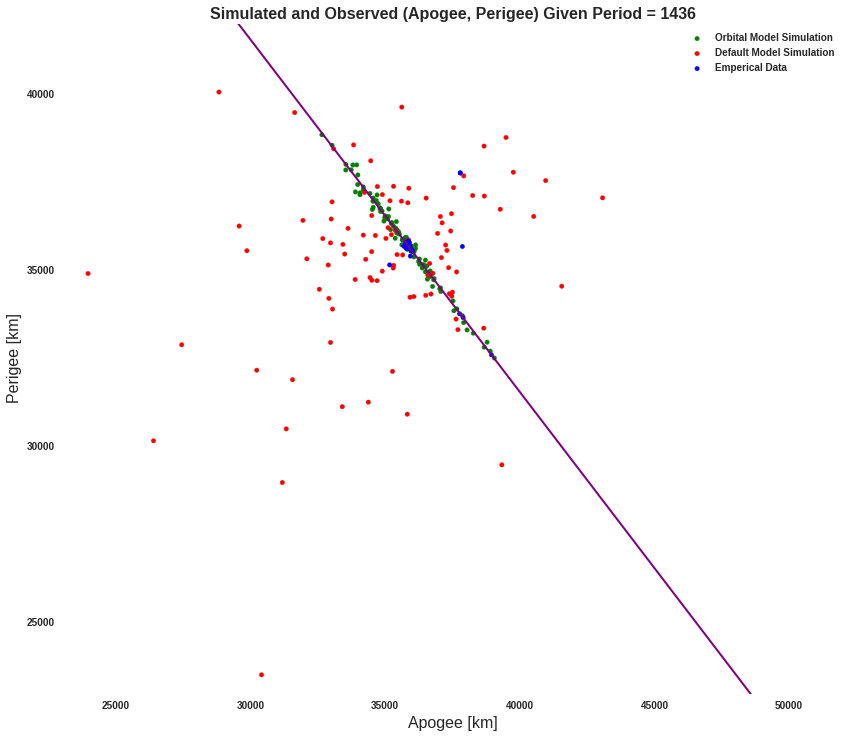

In [9]:
# Simulate from the distribution of (Apogee,Perigee|Period=1436). This query
# represents a probabilistic inversion of Kepler's law, which computes the
# Period from Apogee, Perigee.
T = 1436

KC = q(bdb_kepler, '''
    SIMULATE Apogee_km, Perigee_km FROM sat_custom
        GIVEN Period_minutes = 1436 LIMIT 100;''')

DC = q(bdb_default, '''
    SIMULATE Apogee_km, Perigee_km FROM satellites_cc
        GIVEN Period_minutes = 1436 LIMIT 100;''')

EC = q(bdb_default, '''
    SELECT Apogee_km, Perigee_km FROM satellites
        WHERE Period_minutes BETWEEN 1430 AND 1440
            AND Apogee_km IS NOT NULL
            AND Perigee_km IS NOT NULL;''')

# Plot of the samples.
fig, ax = plt.subplots()
ax.scatter(KC['Apogee_km'], KC['Perigee_km'], color='green',
    label='Orbital Model Simulation')
ax.scatter(DC['Apogee_km'], DC['Perigee_km'], color='red',
    label='Default Model Simulation')
ax.scatter(EC['Apogee_km'], EC['Perigee_km'], color='blue',
    label='Emperical Data')

ecc = np.linspace(-1,1,100)
implied_apogee = (compute_a(T))*(1+ecc) - EARTH_RADIUS
implied_perigee = (compute_a(T))*(1-ecc) - EARTH_RADIUS
ax.plot(implied_perigee, implied_apogee, color='purple')

ax.set_title('Simulated and Observed (Apogee, Perigee) Given Period = 1436',
    fontsize=16)
ax.set_xlabel('Apogee [km]', fontsize=16)
ax.set_ylabel('Perigee [km]', fontsize=16)
ax.set_xlim([23000, 52000])
ax.set_ylim([23000, 42000])
ax.legend();

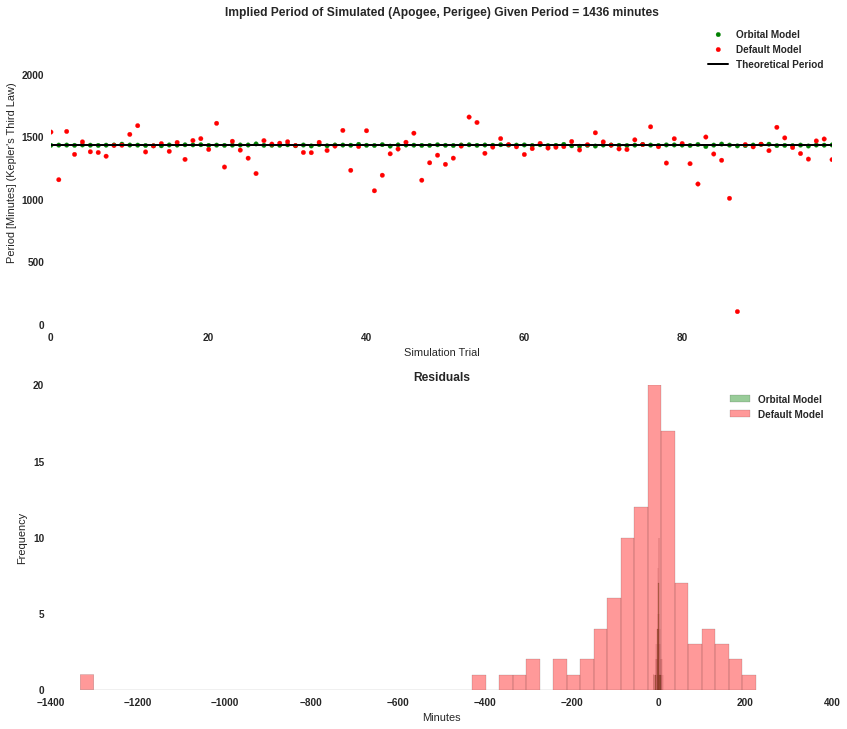

In [10]:
# Plot for Implied Period.
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1)
xs = range(len(KC))

ax.scatter(xs, compute_period(KC['Apogee_km'], KC['Perigee_km']),
    color='green', label='Orbital Model')
ax.scatter(xs, compute_period(DC['Apogee_km'], DC['Perigee_km']),
    color='red', label='Default Model')
ax.hlines(T, min(xs), max(xs), color='black', label='Theoretical Period')

ax.set_title('Implied Period of Simulated (Apogee, Perigee) '
    'Given Period = 1436 minutes')
ax.set_xlabel('Simulation Trial')
ax.set_ylabel('Period [Minutes] (Kepler\'s Third Law)')
ax.set_xlim([min(xs), max(xs)])
ax.set_ylim([0, T+1000])
ax.legend()

#   -- Residual Analysis

KC_resid = compute_period(KC['Apogee_km'], KC['Perigee_km']) - T
DC_resid = compute_period(DC['Apogee_km'], DC['Perigee_km'])  - T

ax2.set_title('Residuals')
ax2.set_xlabel('Minutes')
ax2.set_ylabel('Frequency')

ax2.hist(KC_resid, bins=50, color='green', alpha=0.4,
    label='Orbital Model')
ax2.hist(DC_resid, bins=50, color='red', label='Default Model',
    alpha=0.4)
ax2.legend();

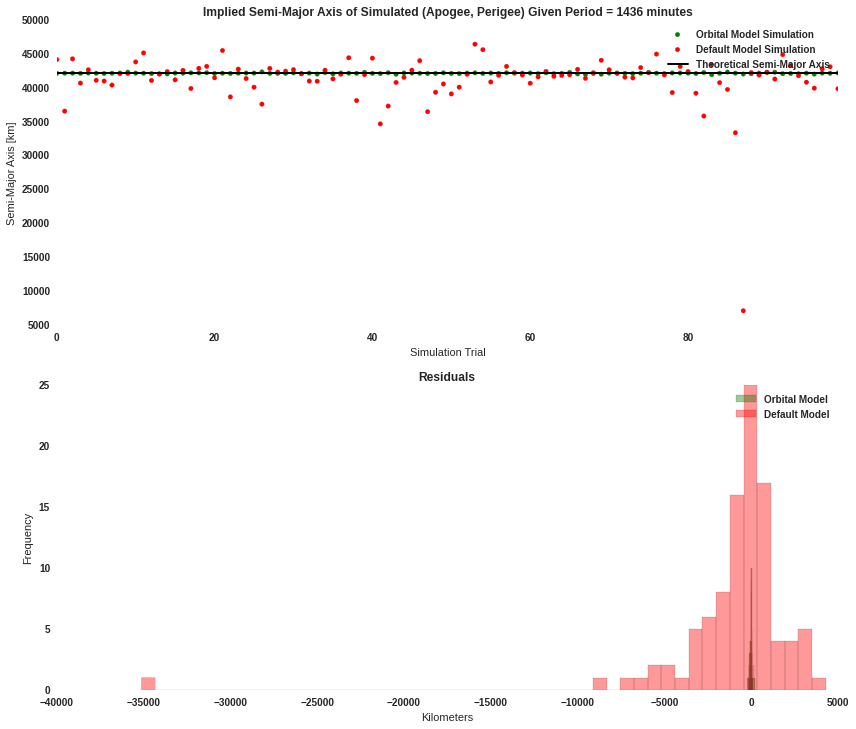

In [11]:
# Plot for Implied Semi-Major Axis.
KC_sma = 0.5*(KC['Apogee_km']+KC['Perigee_km']) + EARTH_RADIUS
DC_sma = 0.5*(DC['Apogee_km']+DC['Perigee_km']) + EARTH_RADIUS

fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1)
xs = range(len(KC))

ax.set_title('Implied Semi-Major Axis of Simulated (Apogee, Perigee) '
    'Given Period = 1436 minutes')
ax.set_xlabel('Simulation Trial')
ax.set_ylabel('Semi-Major Axis [km]')
ax.set_xlim([min(xs), max(xs)])

ax.scatter(xs, KC_sma, color='green', label='Orbital Model Simulation')
ax.scatter(xs, DC_sma, color='red', label='Default Model Simulation')
ax.hlines(compute_a(T), min(xs), max(xs), color='black',
    label='Theoretical Semi-Major Axis')
ax.legend()

#   -- Residual Analysis
KC_resid = KC_sma - compute_a(T)
DC_resid = DC_sma - compute_a(T)

ax2.set_title('Residuals')
ax2.set_xlabel('Kilometers')
ax2.set_ylabel('Frequency')

ax2.hist(KC_resid, bins=50, color='green', alpha=0.4, label='Orbital Model')
ax2.hist(DC_resid, bins=50, color='red', label='Default Model', alpha=0.4)
ax2.legend();

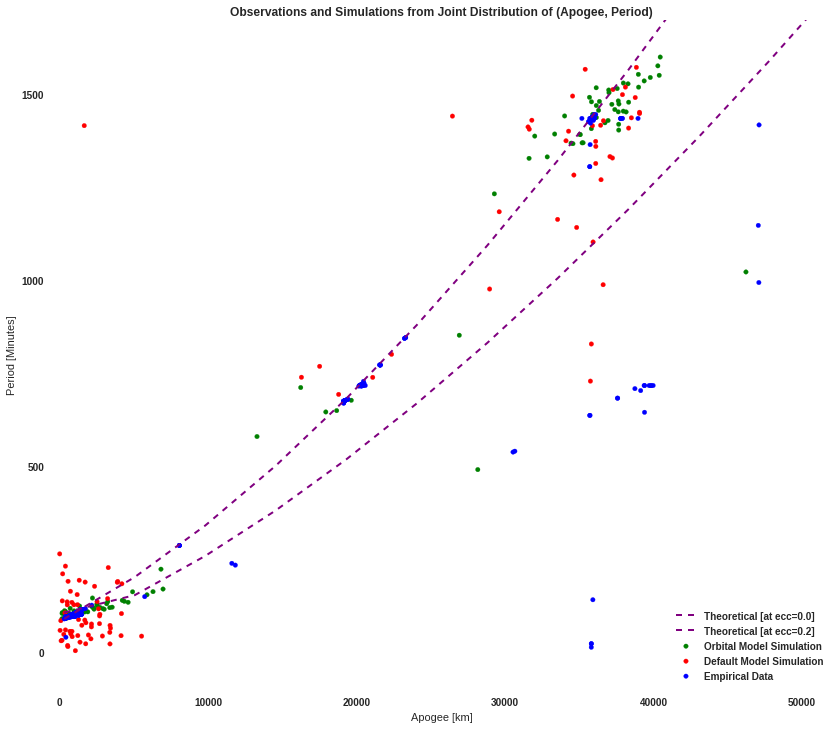

In [12]:
# Apogee vs Period Simulations
KJ = q(bdb_kepler, '''
    SIMULATE Apogee_km, Period_minutes FROM sat_custom LIMIT 100;''')

DJ = q(bdb_default, '''
    SIMULATE Apogee_km, Period_minutes FROM satellites_cc LIMIT 100;''')

EJ = q(bdb_default, '''
    SELECT Apogee_km, Period_minutes FROM satellites
        WHERE Apogee_km IS NOT NULL AND Period_minutes IS NOT NULL;''')

fig, ax = plt.subplots()
ax.scatter(KJ['Apogee_km'], KJ['Period_minutes'],
    color='green', label='Orbital Model Simulation')
ax.scatter(DJ['Apogee_km'], DJ['Period_minutes'],
    color='red', label='Default Model Simulation')
ax.scatter(EJ['Apogee_km'], EJ['Period_minutes'],
    color='blue', label='Empirical Data')

#  -- Parameterize by eccentricity.
apogees = np.linspace(np.min(EJ['Apogee_km']),
    np.max(EJ['Apogee_km']), 100)
perigees_ecc0 = apogees
perigees_ecc2 = (apogees + EARTH_RADIUS) * (1-0.2)/(1+0.2) - EARTH_RADIUS
periods_ecc0 = compute_period(apogees, perigees_ecc0)
periods_ecc2 = compute_period(apogees, (apogees + EARTH_RADIUS) * (1-0.2)/(1+0.2) - EARTH_RADIUS)

ax.plot(apogees, periods_ecc0, color='purple', linestyle='dashed',
    label='Theoretical [at ecc=0.0]')
ax.plot(apogees, periods_ecc2, color='purple', linestyle='dashed',
    label='Theoretical [at ecc=0.2]')

ax.set_title('Observations and Simulations from Joint Distribution of '
    '(Apogee, Period)')
ax.set_xlabel('Apogee [km]')
ax.set_ylabel('Period [Minutes]')
ax.set_xlim([-600, 52000])
ax.set_ylim([-100, 1700])
ax.legend(loc='lower right');